In [1]:
%pip install lifelines

Note: you may need to restart the kernel to use updated packages.


In [10]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
from lifelines.datasets import load_lung

# Load data (lifelines version of survival::lung)

lung = load_lung()

# sex: 1=Male, 2=Female  (same convention as R survival::lung)
lung["sex"] = lung["sex"].map({1: "Male", 2: "Female"}).astype("category")

# status: in R you used status==2 -> event=1 else 0
lung["status"] = np.where(lung["status"] == 2, 1, 0).astype(int)

# drop inst if exists
if "inst" in lung.columns:
    lung = lung.drop(columns=["inst"])

# time in months (R: round(time/30,3)), and drop original time
lung["time_m"] = (lung["time"] / 30.0).round(3)
lung = lung.drop(columns=["time"])

# remove missing
lung_eff = lung.dropna().copy()

# sanity check
print(lung_eff.head())
print(lung_eff["time_m"].describe())


   status  age     sex  ph.ecog  ph.karno  pat.karno  meal.cal  wt.loss  \
1       0   68    Male      0.0      90.0       90.0    1225.0     15.0   
3       0   57    Male      1.0      90.0       60.0    1150.0     11.0   
5       0   74    Male      1.0      50.0       80.0     513.0      0.0   
6       0   68  Female      2.0      70.0       60.0     384.0     10.0   
7       0   71  Female      2.0      60.0       80.0     538.0      1.0   

   time_m  
1  15.167  
3   7.000  
5  34.067  
6  10.333  
7  12.033  
count    168.000000
mean      10.334940
std        6.960437
min        0.167000
25%        5.824750
50%        8.950000
75%       13.875250
max       34.067000
Name: time_m, dtype: float64


In [3]:
import scipy.stats as st

def mh_lognormal_rw(
    logpost_fn,
    init,
    n_sim=2100,
    prop_sd=0.1,
    burn=100,
    thin=5,
    seed=123
):
    """
    Metropolis-Hastings with log-normal random-walk:
      lambda_new ~ LogNormal(meanlog=log(lambda_old), sdlog=prop_sd)

    logpost_fn: function(theta) -> log posterior (up to normalizing constant)
    init: initial theta > 0
    """
    rng = np.random.default_rng(seed)
    chain = np.empty(n_sim, dtype=float)
    chain[0] = init

    accept = 0
    for i in range(1, n_sim):
        old = chain[i-1]
        new = rng.lognormal(mean=np.log(old), sigma=prop_sd)

        lp_new = logpost_fn(new)
        lp_old = logpost_fn(old)

        log_q_old_given_new = st.lognorm(s=prop_sd, scale=np.exp(np.log(new))).logpdf(old)
        log_q_new_given_old = st.lognorm(s=prop_sd, scale=np.exp(np.log(old))).logpdf(new)
        log_prop_ratio = log_q_old_given_new - log_q_new_given_old

        log_acc = lp_new - lp_old + log_prop_ratio

        if np.log(rng.uniform()) < log_acc:
            chain[i] = new
            accept += 1
        else:
            chain[i] = old

    post = chain[burn::thin]
    acc_rate = accept / (n_sim - 1)
    return chain, post, acc_rate


Acceptance rate: 0.160
Posterior draws: 400
Posterior mean: 63.8414941703893
Posterior median: 66.33340763912432


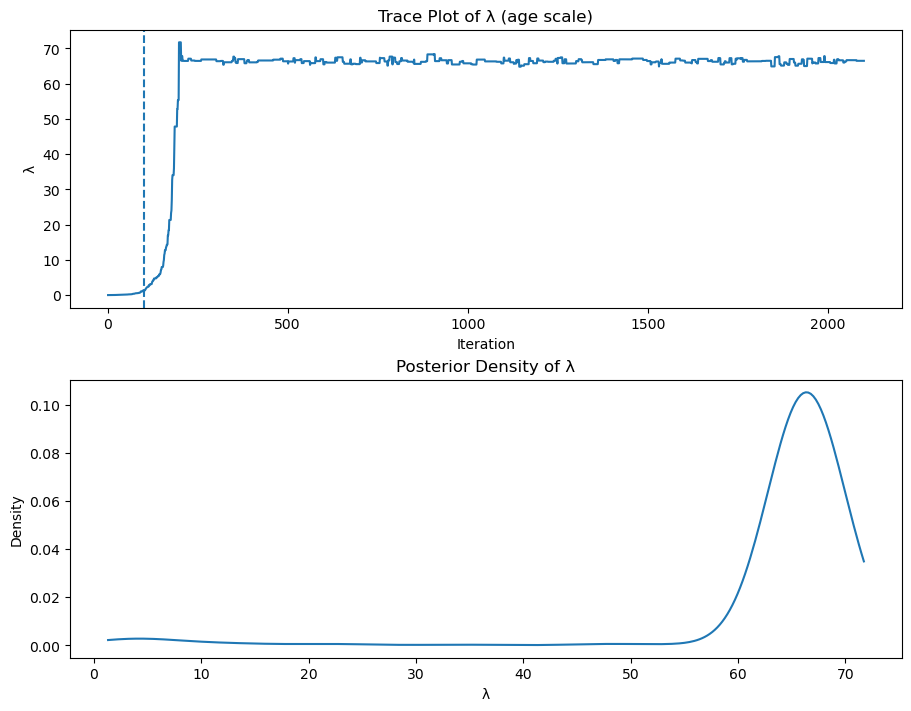

In [15]:
# AGE 
# Prior: weibull
# Likelihood function: phweibull
# Monte Carlo

age = lung_eff["age"].to_numpy()

n_sim = 2100
lam = np.empty(n_sim, dtype=float)
lam[0] = 0.011

shape_fixed = 8
prior_shape = 8
prior_scale = 66

prop_sd = 0.1
burn = 100
thin = 5

rng = np.random.default_rng(123)

def log_posterior(lam_value: float) -> float:
    if lam_value <= 0:
        return -np.inf
    
    loglik = np.sum(st.weibull_min(c=shape_fixed, scale=lam_value).logpdf(age))
    logprior = st.weibull_min(c=prior_shape, scale=prior_scale).logpdf(lam_value)
    return loglik + logprior

# Metropolis-Hastings loop 
# Proposal: lam_new ~ LogNormal(meanlog=log(lam_old), sdlog=prop_sd)
# Includes Hastings correction:
#   log q(lam_old | lam_new) - log q(lam_new | lam_old)

accept = 0

for i in range(1, n_sim):
    lam_old = lam[i - 1]
    lam_new = rng.lognormal(mean=np.log(lam_old), sigma=prop_sd)

    lp_new = log_posterior(lam_new)
    lp_old = log_posterior(lam_old)

    # log proposal ratio:
    # q(x | m) = LogNormal(meanlog=log(m), sdlog=prop_sd)
    # scipy's lognorm parameterization: s=sdlog, scale=exp(meanlog)
    log_q_old_given_new = st.lognorm(s=prop_sd, scale=lam_new).logpdf(lam_old)
    log_q_new_given_old = st.lognorm(s=prop_sd, scale=lam_old).logpdf(lam_new)
    log_prop_ratio = log_q_old_given_new - log_q_new_given_old

    log_acc = (lp_new - lp_old) + log_prop_ratio

    if np.log(rng.uniform()) < log_acc:
        lam[i] = lam_new
        accept += 1
    else:
        lam[i] = lam_old

acc_rate = accept / (n_sim - 1)
print(f"Acceptance rate: {acc_rate:.3f}")

# burn-in & thinning (R: lambda_post <- lambda[seq(101, n.sim, by=5)])

lam_post = lam[burn::thin]
print("Posterior draws:", lam_post.size)
print("Posterior mean:", lam_post.mean())
print("Posterior median:", np.median(lam_post))

# Plot: trace + posterior density (matplotlib)

fig, axes = plt.subplots(2, 1, figsize=(9, 7), constrained_layout=True)

# Trace plot
axes[0].plot(np.arange(1, n_sim + 1), lam)
axes[0].axvline(burn, linestyle="--")  # burn-in marker (same as R red dashed line, no fixed color requirement here)
axes[0].set_title("Trace Plot of λ (age scale)")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("λ")

# Density plot (KDE-like via histogram density + optional gaussian_kde)
xs = np.linspace(lam_post.min(), lam_post.max(), 300)
kde = st.gaussian_kde(lam_post)
axes[1].plot(xs, kde(xs))
axes[1].set_title("Posterior Density of λ")
axes[1].set_xlabel("λ")
axes[1].set_ylabel("Density")

plt.show()

Meal.cal MH acceptance rate: 0.394
Posterior draws: 400
Posterior mean: 1041.498562696439
Posterior median: 1038.2754837465745


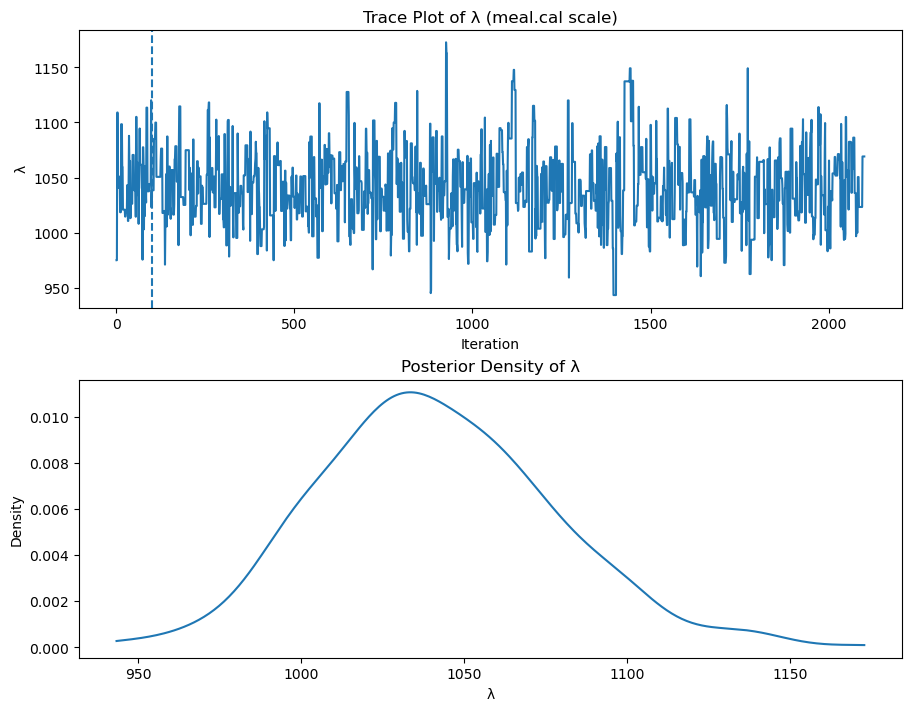

In [12]:
# Meal.cal
# Prior: weibull
# Likelihood function: phWeibull
# Monte Carlo

meal = lung_eff["meal.cal"].to_numpy()

n_sim = 2100
lam = np.empty(n_sim, dtype=float)

# R: lambda[1] <- 975  # median(lung_eff$meal.cal)
lam[0] = 975.0

shape_fixed = 2.3
prior_shape = 2.3
prior_scale = 1045.0

prop_sd = 0.1
burn = 100   # R: vertical line at 100, and start posterior at 101
thin = 5

rng = np.random.default_rng(123)

# Log-posterior (likelihood for meal + prior for lambda)
#    Likelihood: meal_i ~ Weibull(shape_fixed, scale=lam)
#    Prior: lam ~ Weibull(prior_shape, prior_scale)

weib_prior = st.weibull_min(c=prior_shape, scale=prior_scale)

def log_posterior(lam_value: float) -> float:
    if lam_value <= 0:
        return -np.inf
    loglik = np.sum(st.weibull_min(c=shape_fixed, scale=lam_value).logpdf(meal))
    logprior = weib_prior.logpdf(lam_value)
    return loglik + logprior


#  Metropolis-Hastings with LogNormal random-walk proposal
#    Proposal: lam_new ~ LogNormal(meanlog=log(lam_old), sdlog=prop_sd)
#    Hastings correction: log q(lam_old|lam_new) - log q(lam_new|lam_old)

accept = 0

for i in range(1, n_sim):
    lam_old = lam[i - 1]
    lam_new = rng.lognormal(mean=np.log(lam_old), sigma=prop_sd)

    lp_new = log_posterior(lam_new)
    lp_old = log_posterior(lam_old)

 
    log_q_old_given_new = st.lognorm(s=prop_sd, scale=lam_new).logpdf(lam_old)
    log_q_new_given_old = st.lognorm(s=prop_sd, scale=lam_old).logpdf(lam_new)
    log_prop_ratio = log_q_old_given_new - log_q_new_given_old

    log_acc = (lp_new - lp_old) + log_prop_ratio

    if np.log(rng.uniform()) < log_acc:
        lam[i] = lam_new
        accept += 1
    else:
        lam[i] = lam_old

acc_rate = accept / (n_sim - 1)
print(f"Meal.cal MH acceptance rate: {acc_rate:.3f}")

#  burn-in & thinning (R: lambda[seq(101, n.sim, by=5)])
#    R is 1-based: 101 -> Python index 100

lam_post = lam[burn::thin]
print("Posterior draws:", lam_post.size)
print("Posterior mean:", float(lam_post.mean()))
print("Posterior median:", float(np.median(lam_post)))

# trace + posterior density

fig, axes = plt.subplots(2, 1, figsize=(9, 7), constrained_layout=True)

# Trace plot
axes[0].plot(np.arange(1, n_sim + 1), lam)
axes[0].axvline(burn, linestyle="--")
axes[0].set_title("Trace Plot of λ (meal.cal scale)")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("λ")

# Density plot (KDE)
xs = np.linspace(lam_post.min(), lam_post.max(), 300)
kde = st.gaussian_kde(lam_post)
axes[1].plot(xs, kde(xs))
axes[1].set_title("Posterior Density of λ")
axes[1].set_xlabel("λ")
axes[1].set_ylabel("Density")

plt.show()


Wt.Loss MH acceptance rate: 0.322
Posterior draws: 400
Posterior mean: 39.9983122367158
Posterior median: 39.96717088415044


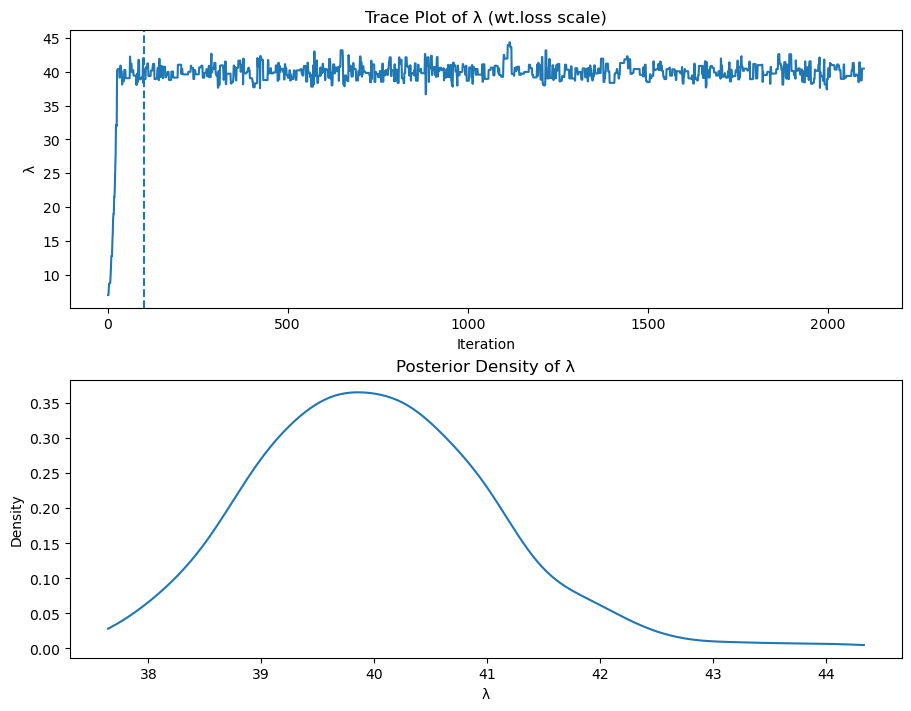

In [14]:
# Wt.Loss
# Prior: gamma
# Likelihood function: phWeibull
# Monte Carlo

wt_loss_pos = (lung_eff["wt.loss"].to_numpy() + 25.0)

n_sim = 2100
lam = np.empty(n_sim, dtype=float)

# R: lambda[1] <- 7
lam[0] = 7.0

shape_fixed = 3
prior_shape = 3
prior_scale = 39.0

prop_sd = 0.1
burn = 100
thin = 5

rng = np.random.default_rng(123)

# log-posterior
#   Likelihood: wt_loss_pos ~ Weibull(shape_fixed, scale=lambda)
#   Prior: lambda ~ Gamma(shape=prior_shape, scale=prior_scale)

gamma_prior = st.gamma(a=prior_shape, scale=prior_scale)

def log_posterior(lam_value: float) -> float:
    if lam_value <= 0:
        return -np.inf

    loglik = np.sum(
        st.weibull_min(c=shape_fixed, scale=lam_value).logpdf(wt_loss_pos)
    )
    logprior = gamma_prior.logpdf(lam_value)
    return loglik + logprior


# Metropolis–Hastings
#   Proposal: LogNormal(log(lambda_old), 0.1)
#   Hastings correction included

accept = 0

for i in range(1, n_sim):
    lam_old = lam[i - 1]
    lam_new = rng.lognormal(mean=np.log(lam_old), sigma=prop_sd)

    lp_new = log_posterior(lam_new)
    lp_old = log_posterior(lam_old)

    # proposal ratio:
    # q(x | m) = LogNormal(meanlog=log(m), sdlog=prop_sd)
    log_q_old_given_new = st.lognorm(s=prop_sd, scale=lam_new).logpdf(lam_old)
    log_q_new_given_old = st.lognorm(s=prop_sd, scale=lam_old).logpdf(lam_new)
    log_prop_ratio = log_q_old_given_new - log_q_new_given_old

    log_acc = (lp_new - lp_old) + log_prop_ratio

    if np.log(rng.uniform()) < log_acc:
        lam[i] = lam_new
        accept += 1
    else:
        lam[i] = lam_old

acc_rate = accept / (n_sim - 1)
print(f"Wt.Loss MH acceptance rate: {acc_rate:.3f}")

# burn-in & thinning
#   R: lambda[seq(101, n.sim, by=5)]

lam_post = lam[burn::thin]

print("Posterior draws:", lam_post.size)
print("Posterior mean:", float(lam_post.mean()))
print("Posterior median:", float(np.median(lam_post)))


# Trace plot + posterior density

fig, axes = plt.subplots(2, 1, figsize=(9, 7), constrained_layout=True)

# Trace plot
axes[0].plot(np.arange(1, n_sim + 1), lam)
axes[0].axvline(burn, linestyle="--")
axes[0].set_title("Trace Plot of λ (wt.loss scale)")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("λ")

# Density plot (KDE)
xs = np.linspace(lam_post.min(), lam_post.max(), 300)
kde = st.gaussian_kde(lam_post)
axes[1].plot(xs, kde(xs))
axes[1].set_title("Posterior Density of λ")
axes[1].set_xlabel("λ")
axes[1].set_ylabel("Density")

plt.show()